In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/dogs-vs-cats.zip

Archive:  /content/drive/MyDrive/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [3]:
!unzip /content/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

In [4]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=567, end_index=1567)
make_subset("validation", start_index=1568, end_index=2068)
make_subset("test", start_index=2069, end_index=2569)

Data Preprocessing

In [5]:
##Organizing the file directory: Partitioning the file system into train (1000), test (500), and validation (500) folders.
from tensorflow.keras.utils import image_dataset_from_directory

training_datasets = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
valid_datasets = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
testing_datasets = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Create a dataset instance from a NumPy array containing 1000 samples, each consisting of a vector of size 16 filled with random numbers.

In [6]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

Splitting the data into batches of size 32.

In [7]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [8]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [9]:
Reshaped_Dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(Reshaped_Dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Visualize the structures of the data and labels contained within the Dataset.

In [10]:
for data_batch, labels_batch in training_datasets:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Implementing a small convnet for classification of cats and dogs.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
a = layers.Rescaling(1./255)(inputs)
a = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.Flatten()(a)
a = layers.Dropout(0.5)(a)
outputs = layers.Dense(1, activation="sigmoid")(a)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Summary

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
      keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=30,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 15s 122ms/step - loss: 0.6945 - accuracy: 0.5205 - val_loss: 0.6923 - val_accuracy: 0.5060
Epoch 2/30
63/63 [==============================] - 5s 83ms/step - loss: 0.6836 - accuracy: 0.5635 - val_loss: 0.6837 - val_accuracy: 0.5450
Epoch 3/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6777 - accuracy: 0.5660 - val_loss: 0.6528 - val_accuracy: 0.6230
Epoch 4/30
63/63 [==============================] - 4s 58ms/step - loss: 0.6483 - accuracy: 0.6290 - val_loss: 0.6378 - val_accuracy: 0.6350
Epoch 5/30
63/63 [==============================] - 6s 94ms/step - loss: 0.6146 - accuracy: 0.6570 - val_loss: 0.6787 - val_accuracy: 0.5700
Epoch 6/30
63/63 [==============================] - 4s 58ms/step - loss: 0.5924 - accuracy: 0.6925 - val_loss: 0.6078 - val_accuracy: 0.6930
Epoch 7/30
63/63 [==============================] - 4s 57ms/step - loss: 0.5342 - accuracy: 0.7440 - val_loss: 0.5899 - val_accuracy: 0.7040
Epoch 8/30


Showing the plots illustrating the training progress, including the loss and accuracy curves.

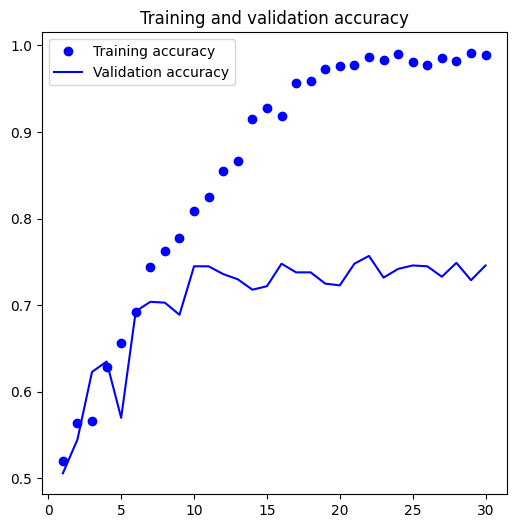

<Figure size 640x480 with 0 Axes>

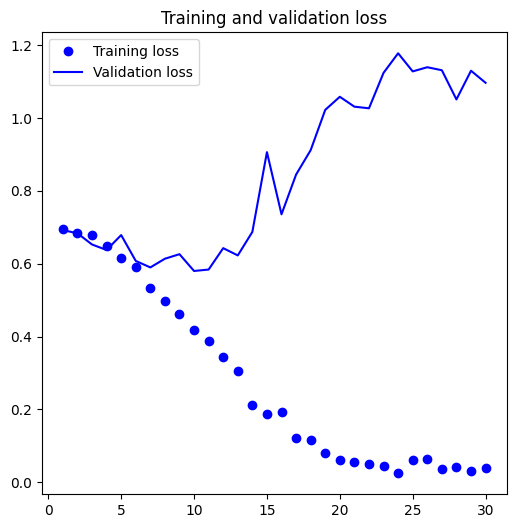

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(6, 6))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 27ms/step - loss: 0.5816 - accuracy: 0.7420
Test accuracy: 0.742


Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

In [17]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=567, end_index=2067)
make_subset("validation", start_index=2068, end_index=2568)
make_subset("test", start_index=2569, end_index=3068)

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Show randomly modified training images with augmentation applied.

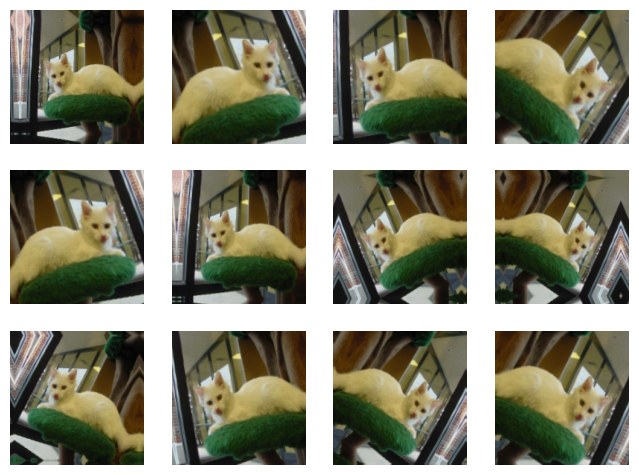

In [24]:
plt.figure(figsize=(8, 8))
for images, _ in training_datasets.take(1):
    for i in range(12):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Create a novel convolutional neural network with image augmentation and dropout integration.

In [25]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=60,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/60
63/63 [==============================] - 11s 115ms/step - loss: 0.6975 - accuracy: 0.5110 - val_loss: 0.6900 - val_accuracy: 0.5290
Epoch 2/60
63/63 [==============================] - 5s 70ms/step - loss: 0.6910 - accuracy: 0.5300 - val_loss: 0.6767 - val_accuracy: 0.5540
Epoch 3/60
63/63 [==============================] - 4s 57ms/step - loss: 0.6807 - accuracy: 0.5510 - val_loss: 0.6773 - val_accuracy: 0.5760
Epoch 4/60
63/63 [==============================] - 6s 85ms/step - loss: 0.6737 - accuracy: 0.5920 - val_loss: 0.6776 - val_accuracy: 0.5490
Epoch 5/60
63/63 [==============================] - 6s 91ms/step - loss: 0.6599 - accuracy: 0.6130 - val_loss: 0.6506 - val_accuracy: 0.6190
Epoch 6/60
63/63 [==============================] - 4s 57ms/step - loss: 0.6537 - accuracy: 0.6255 - val_loss: 0.6539 - val_accuracy: 0.6040
Epoch 7/60
63/63 [==============================] - 4s 58ms/step - loss: 0.6364 - accuracy: 0.6215 - val_loss: 0.6667 - val_accuracy: 0.5900
Epoch 8/60


Assessing the model's performance on the test dataset.

In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 28ms/step - loss: 0.4587 - accuracy: 0.7960
Test accuracy: 0.796


Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Augmenting the training dataset to 2000 samples while maintaining the validation and test sets at 500 samples each.

In [28]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2667)
make_subset("validation", start_index=2668, end_index=3168)
make_subset("test", start_index=3169, end_index=3669)

Create a novel convolutional neural network with augmented training data and enhanced dropout regularization.

In [29]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=50,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 90ms/step - loss: 0.6948 - accuracy: 0.4920 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 4s 58ms/step - loss: 0.6922 - accuracy: 0.5230 - val_loss: 0.6914 - val_accuracy: 0.5160
Epoch 3/50
63/63 [==============================] - 5s 81ms/step - loss: 0.6767 - accuracy: 0.5795 - val_loss: 0.6758 - val_accuracy: 0.5360
Epoch 4/50
63/63 [==============================] - 4s 59ms/step - loss: 0.6736 - accuracy: 0.5865 - val_loss: 0.6402 - val_accuracy: 0.6580
Epoch 5/50
63/63 [==============================] - 4s 68ms/step - loss: 0.6447 - accuracy: 0.6170 - val_loss: 0.6669 - val_accuracy: 0.5840
Epoch 6/50
63/63 [==============================] - 7s 100ms/step - loss: 0.6570 - accuracy: 0.6220 - val_loss: 0.6425 - val_accuracy: 0.6360
Epoch 7/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6188 - accuracy: 0.6585 - val_loss: 0.5922 - val_accuracy: 0.6790
Epoch 8/50
6

In [48]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.4497 - accuracy: 0.8010
Test accuracy: 0.801



--A basic convolutional neural network (CNN) initially trained on 1,000 examples achieved a classification accuracy of approximately 70%, with overfitting identified as the primary concern. To enhance the model, optimization methods such as data augmentation, early stopping, regularization, and dropout were applied. Implementing data augmentation led to an accuracy increase to 80%, indicating a significant performance improvement. To further refine classification accuracy, efforts focused on selecting optimal training samples and addressing overfitting. Strategies included adjusting the training set, incorporating weight regularization and dropout, reducing network capacity, and expanding the training dataset size. These techniques effectively mitigated overfitting and improved the model's generalization ability.

Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Initializing the VGG16 convolutional base.

In [31]:
convolution_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [32]:
convolution_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Performing feature extraction without applying data augmentation using a pre-trained model.

Retrieve the VGG16 features along with their respective labels.

In [33]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convolution_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(training_datasets)
val_features, val_labels =  get_features_and_labels(valid_datasets)
test_features, test_labels =  get_features_and_labels(testing_datasets)

1/1 [==============================] - 0s 20ms/step


In [34]:
train_features.shape

(2000, 5, 5, 512)

Creating and training the densely connected classifier.

In [35]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 1s 9ms/step - loss: 17.9067 - accuracy: 0.9255 - val_loss: 3.4493 - val_accuracy: 0.9710
Epoch 2/30
63/63 [==============================] - 0s 6ms/step - loss: 2.6798 - accuracy: 0.9770 - val_loss: 3.6614 - val_accuracy: 0.9690
Epoch 3/30
63/63 [==============================] - 1s 8ms/step - loss: 2.4375 - accuracy: 0.9805 - val_loss: 2.5617 - val_accuracy: 0.9830
Epoch 4/30
63/63 [==============================] - 0s 5ms/step - loss: 1.2861 - accuracy: 0.9920 - val_loss: 4.7444 - val_accuracy: 0.9720
Epoch 5/30
63/63 [==============================] - 0s 6ms/step - loss: 0.6649 - accuracy: 0.9910 - val_loss: 5.6983 - val_accuracy: 0.9720
Epoch 6/30
63/63 [==============================] - 0s 5ms/step - loss: 0.4261 - accuracy: 0.9925 - val_loss: 6.1308 - val_accuracy: 0.9750
Epoch 7/30
63/63 [==============================] - 0s 5ms/step - loss: 0.3819 - accuracy: 0.9950 - val_loss: 5.5036 - val_accuracy: 0.9750
Epoch 8/30
63/63 [=

Visualizing the outcomes.

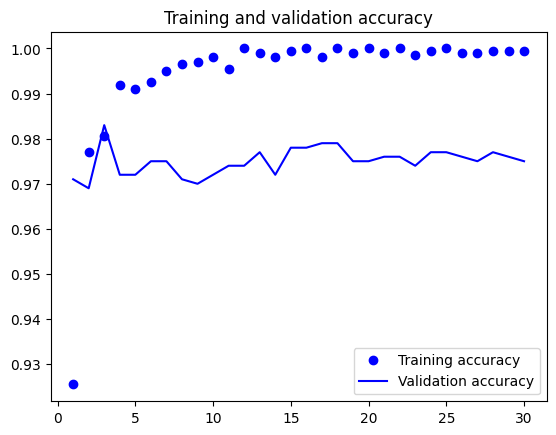

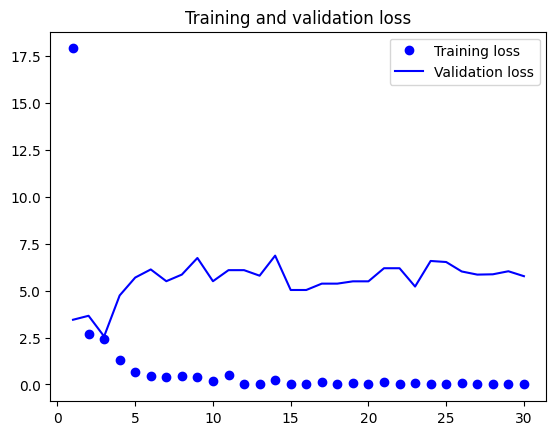

In [36]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Performing feature extraction with data augmentation utilizing a pre-trained model.

Initializing and immobilizing the VGG16 convolutional base.

In [37]:
convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
convolution_base.trainable = False

In [39]:
convolution_base.trainable = True
print("This is the number of trainable weights "
      "before immobilizing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights before immobilizing the conv base: 26


In [40]:
convolution_base.trainable = False
print("This is the number of trainable weights "
      "after immobilizing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights after immobilizing the conv base: 0


Incorporating a data augmentation step and classifier into the convolutional base.

In [41]:
augmentation2 = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.2),
layers.RandomZoom(0.3),
]
)
input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
x1 =keras.layers.Lambda(
lambda x: keras.applications.vgg16.preprocess_input(x))(x1)
x1 = convolution_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=60,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/60
63/63 [==============================] - 12s 162ms/step - loss: 24.4819 - accuracy: 0.8505 - val_loss: 5.4288 - val_accuracy: 0.9670
Epoch 2/60
63/63 [==============================] - 11s 157ms/step - loss: 10.9200 - accuracy: 0.9155 - val_loss: 5.7500 - val_accuracy: 0.9660
Epoch 3/60
63/63 [==============================] - 12s 191ms/step - loss: 10.4666 - accuracy: 0.9215 - val_loss: 4.7523 - val_accuracy: 0.9610
Epoch 4/60
63/63 [==============================] - 12s 188ms/step - loss: 7.3288 - accuracy: 0.9310 - val_loss: 4.0268 - val_accuracy: 0.9660
Epoch 5/60
63/63 [==============================] - 10s 147ms/step - loss: 8.6131 - accuracy: 0.9325 - val_loss: 5.0100 - val_accuracy: 0.9620
Epoch 6/60
63/63 [==============================] - 12s 183ms/step - loss: 6.8587 - accuracy: 0.9410 - val_loss: 3.8651 - val_accuracy: 0.9760
Epoch 7/60
63/63 [==============================] - 10s 158ms/step - loss: 5.9522 - accuracy: 0.9355 - val_loss: 3.0673 - val_accuracy: 0.9

Assessing the model's performance on the test dataset.

In [43]:
test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras",safe_mode=False)
test_loss, test_acc = test_model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 90ms/step - loss: 0.6715 - accuracy: 0.9750
Test accuracy: 0.975


--A pretrained VGG16 model with Fine-tuning:

Fine-tuning involves unfreezing select top layers of a previously frozen model foundation utilized for feature extraction. This process concurrently trains both the newly added model component (in this scenario, the fully connected classifier) and these unfrozen layers. This iterative adjustment is termed fine-tuning, as it adapts the model's abstract representations to better suit the current task.


In [44]:
convolution_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [45]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-5]:
    layer.trainable = False

Fine-tuning the model:

In [46]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_datasets,
    epochs=35,
    validation_data=valid_datasets,
    callbacks=callbacks)

Epoch 1/35
63/63 [==============================] - 14s 188ms/step - loss: 0.4888 - accuracy: 0.9675 - val_loss: 0.5913 - val_accuracy: 0.9760
Epoch 2/35
63/63 [==============================] - 11s 176ms/step - loss: 0.4205 - accuracy: 0.9665 - val_loss: 0.6671 - val_accuracy: 0.9760
Epoch 3/35
63/63 [==============================] - 13s 199ms/step - loss: 0.4019 - accuracy: 0.9715 - val_loss: 0.6701 - val_accuracy: 0.9760
Epoch 4/35
63/63 [==============================] - 11s 179ms/step - loss: 0.2990 - accuracy: 0.9730 - val_loss: 0.5509 - val_accuracy: 0.9780
Epoch 5/35
63/63 [==============================] - 11s 167ms/step - loss: 0.2896 - accuracy: 0.9760 - val_loss: 0.6041 - val_accuracy: 0.9750
Epoch 6/35
63/63 [==============================] - 12s 178ms/step - loss: 0.3389 - accuracy: 0.9730 - val_loss: 0.5091 - val_accuracy: 0.9760
Epoch 7/35
63/63 [==============================] - 10s 162ms/step - loss: 0.1981 - accuracy: 0.9740 - val_loss: 0.6135 - val_accuracy: 0.9690

In [47]:
model = keras.models.load_model("fine_tuning.keras",safe_mode=False)
test_loss, test_acc = model.evaluate(testing_datasets)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 92ms/step - loss: 0.4249 - accuracy: 0.9770
Test accuracy: 0.977
